# Import

In [49]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import optuna
import pickle
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import root_mean_squared_log_error, mean_squared_log_error, mean_squared_error, r2_score

import logging
logging.basicConfig(level=logging.ERROR)
plt.rcParams['figure.figsize'] = [21, 9]
plt.rcParams['figure.dpi'] = 300

# 다크모드에 맞는 스타일 설정
plt.style.use('dark_background')

# 추가적인 커스터마이징 (옵션)
plt.rcParams.update({
    'axes.edgecolor': 'white',         # 축의 테두리 색상
    'axes.labelcolor': 'white',       # 축 라벨 색상
    'xtick.color': 'white',           # x축 눈금 색상
    'ytick.color': 'white',           # y축 눈금 색상
    'grid.color': 'gray',             # 그리드 라인 색상
    'grid.alpha': 0.3,                # 그리드 투명도
    'text.color': 'white',            # 텍스트 색상
    'figure.facecolor': '#121212',    # 전체 그림 배경색
    'axes.facecolor': '#121212',      # 축 배경색
    'legend.facecolor': '#1e1e1e',    # 범례 배경색
    'legend.edgecolor': 'white',      # 범례 테두리 색상
})
plt.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
REDRAW = False

Original dataset: https://www.kaggle.com/datasets/schran/insurance-premium-prediction/data

# Load Data

In [65]:
# 캐글 노트북이면 True, 아니면 False
if 'KAGGLE_URL_BASE' in os.environ:
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col=0)
else:
    train_data = pd.read_csv('./kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('./kaggle/input/playground-series-s4e12/test.csv', index_col=0)

In [66]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

# 타겟 변수 및 피처 분리
target_column = 'premium_amount'
data = pd.concat([train_data, test_data]).drop(columns=target_column)
y = train_data[target_column].values
del train_data, test_data

In [67]:
# policy_start_date 피처 전처리
data['policy_start_date'] = pd.to_datetime(data['policy_start_date'])
data['policy_start_date'] = (data['policy_start_date'] - pd.to_datetime('1970-01-01')).dt.days

In [ ]:
# --- 2. 결측치 처리 ---

# number_of_dependents, insurance_duration, previous_claims is categorical
data['number_of_dependents'] = data['number_of_dependents'].apply(lambda x: str(x))
data['insurance_duration'] = data['insurance_duration'].apply(lambda x: str(x))
data['previous_claims'] = data['previous_claims'].apply(lambda x: str(x))


# age to binned, vehicle_age to binned
data['age'] = pd.qcut(data['age'], q=8, duplicates='raise')
data['vehicle_age'] = pd.qcut(data['vehicle_age'], q=8, duplicates='raise')


categorical_columns = data.select_dtypes(include=['object', 'category']).columns
ordinal_categories = ['age', 'vehicle_age', 'number_of_dependents', 'insurance_duration', 'previous_claims']
categorical_columns = categorical_columns.drop(ordinal_categories)

# 범주형 변수의 결측치를 'unknown'으로 대체
for col in categorical_columns:
    data[col].fillna('unknown', inplace=True)


# 수치형 변수의 결측치를 최대값 + 10%로 대체
float_columns = data.select_dtypes(include=['float64']).columns
for col in float_columns:
    data[col].fillna(data[col].max() * 1.1, inplace=True)
    
int_columns = data.select_dtypes(include=['int64']).columns
for col in int_columns:
    data[col].fillna(data[col].max()+int(data[col].std()), inplace=True)
numerical_columns = float_columns.append(int_columns)

# --- 3. 범주형 변수 인코딩 및 수치형 스케일링 ---
# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    
    
# 순서 범주형 변수 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)
data[ordinal_categories] = ordinal_encoder.fit_transform(data[ordinal_categories])

# 수치형 변수 스케일링
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])


y = data.premium_amount.dropna().values
y_scaler = StandardScaler()
y_scaler.fit(np.log1p(y).reshape(-1,1))
# y_scaler_torch = TorchStandardScaler()
# y_scaler_torch.fit(torch.tensor(torch.log1p(torch.tensor(y, dtype=torch.float32).to(device)).squeeze(-1)))
y = y_scaler.transform(np.log1p(y).reshape(-1,1)).reshape(-1)

data[target_column] = np.pad(y, (0, data.shape[0]-len(y)), 'constant', constant_values=np.nan)

X = data[:len(y)].drop(columns=target_column).copy()

# Devide Dataset

In [24]:
# drop features: 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'

# X = data.loc[data[target_column].notnull(), ].drop(columns=[target_column, 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'])

In [71]:
def inverse_y(y):
    return np.expm1(y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1))

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.2, random_state=42)

# Modeling

In [73]:
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    
    
    y_pred = inverse_y(y_pred)
    y_val = inverse_y(y_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

def evaluate_model_no_inverse(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    # y_pred = inverse_y(y_pred)
    # y_val = inverse_y(y_val)
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

In [74]:
# TODO: LightGBM Regressor

lgbm = LGBMRegressor(
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=30,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    gpu_id=0,
    device_type='gpu',
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 19
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 19 dense feature groups (18.31 MB) transferred to GPU in 0.022371 secs. 0 sparse feature groups
[LightGBM] [Warning] Unknown parameter: gpu_id
[LightGBM] [Info] Start training from score -0.000037
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [D

LGBMRegressor(device_type='gpu', gpu_id=0, max_depth=30, min_child_samples=7,
              min_child_weight=0.003, n_estimators=500, n_jobs=-1,
              random_state=42, verbosity=10)

In [75]:
evaluate_model(lgbm, X_val, y_val)

[LightGBM] [Warning] Unknown parameter: gpu_id


(0.08903629778608035, 0.911942013929531, 1.046464533765779)

In [ ]:
def mlse_with_inverse(preds, dtrain: np.ndarray):
    dtrain = inverse_y(dtrain)
    preds = inverse_y(preds)

    # preds = np.maximum(preds, epsilon)
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    try:
        return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False
    except:
        return 'RMLSE', 10, False

In [45]:
# optuna parameter search near num_leaves=31, min_child_samples=7, min_child_weight=0.003, n_estimators=500, max_depth=30, learning_rate=0.1 and wide range search for other parameters
y_val_origin = inverse_y(y_val)
def objective(trial: optuna.Trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 400, 600),
        'max_depth': trial.suggest_int('max_depth', 20, 40),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        
    }
    
    lgbm = LGBMRegressor(
        gpu_id=0,
        n_jobs=-1,
        device_type='gpu',
        verbosity=-1,
        **params,
    )
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    pred = lgbm.predict(X_val)
    ret = np.sqrt(np.average(np.power(np.log1p(y_val_origin) - np.log1p(inverse_y(pred)), 2)))
    return ret

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=750, )

[I 2024-12-26 03:33:12,831] A new study created in memory with name: no-name-3cb0c7dc-2748-47a2-83dd-5e33ef48faf0
[I 2024-12-26 03:34:07,232] Trial 0 finished with value: 1.0473473784865268 and parameters: {'num_leaves': 31, 'min_child_samples': 7, 'min_child_weight': 0.008782543887641438, 'n_estimators': 412, 'max_depth': 26, 'learning_rate': 0.04109944785421931, 'feature_fraction': 0.9038282101534575, 'bagging_fraction': 0.6979757311190028, 'lambda_l1': 2.128137268395003, 'lambda_l2': 0.04969347966643729, 'reg_alpha': 0.06257393242541691, 'reg_lambda': 0.008675735644629945, 'boosting_type': 'dart'}. Best is trial 0 with value: 1.0473473784865268.
[I 2024-12-26 03:34:45,172] Trial 1 finished with value: 1.0467429106691346 and parameters: {'num_leaves': 23, 'min_child_samples': 10, 'min_child_weight': 0.0868190009684596, 'n_estimators': 443, 'max_depth': 34, 'learning_rate': 0.18658521278630638, 'feature_fraction': 0.8973301835120595, 'bagging_fraction': 0.9409900718267662, 'lambda_l1'

In [46]:
study.best_params, study.best_value

({'num_leaves': 40,
  'min_child_samples': 10,
  'min_child_weight': 0.06465924287223622,
  'n_estimators': 459,
  'max_depth': 30,
  'learning_rate': 0.046995524079346984,
  'feature_fraction': 0.9677961468326596,
  'bagging_fraction': 0.6627290192138932,
  'lambda_l1': 8.692580281983838,
  'lambda_l2': 3.4256066884728638,
  'reg_alpha': 0.08455745202708774,
  'reg_lambda': 0.007744807329888691,
  'boosting_type': 'gbdt'},
 1.0462689704206725)

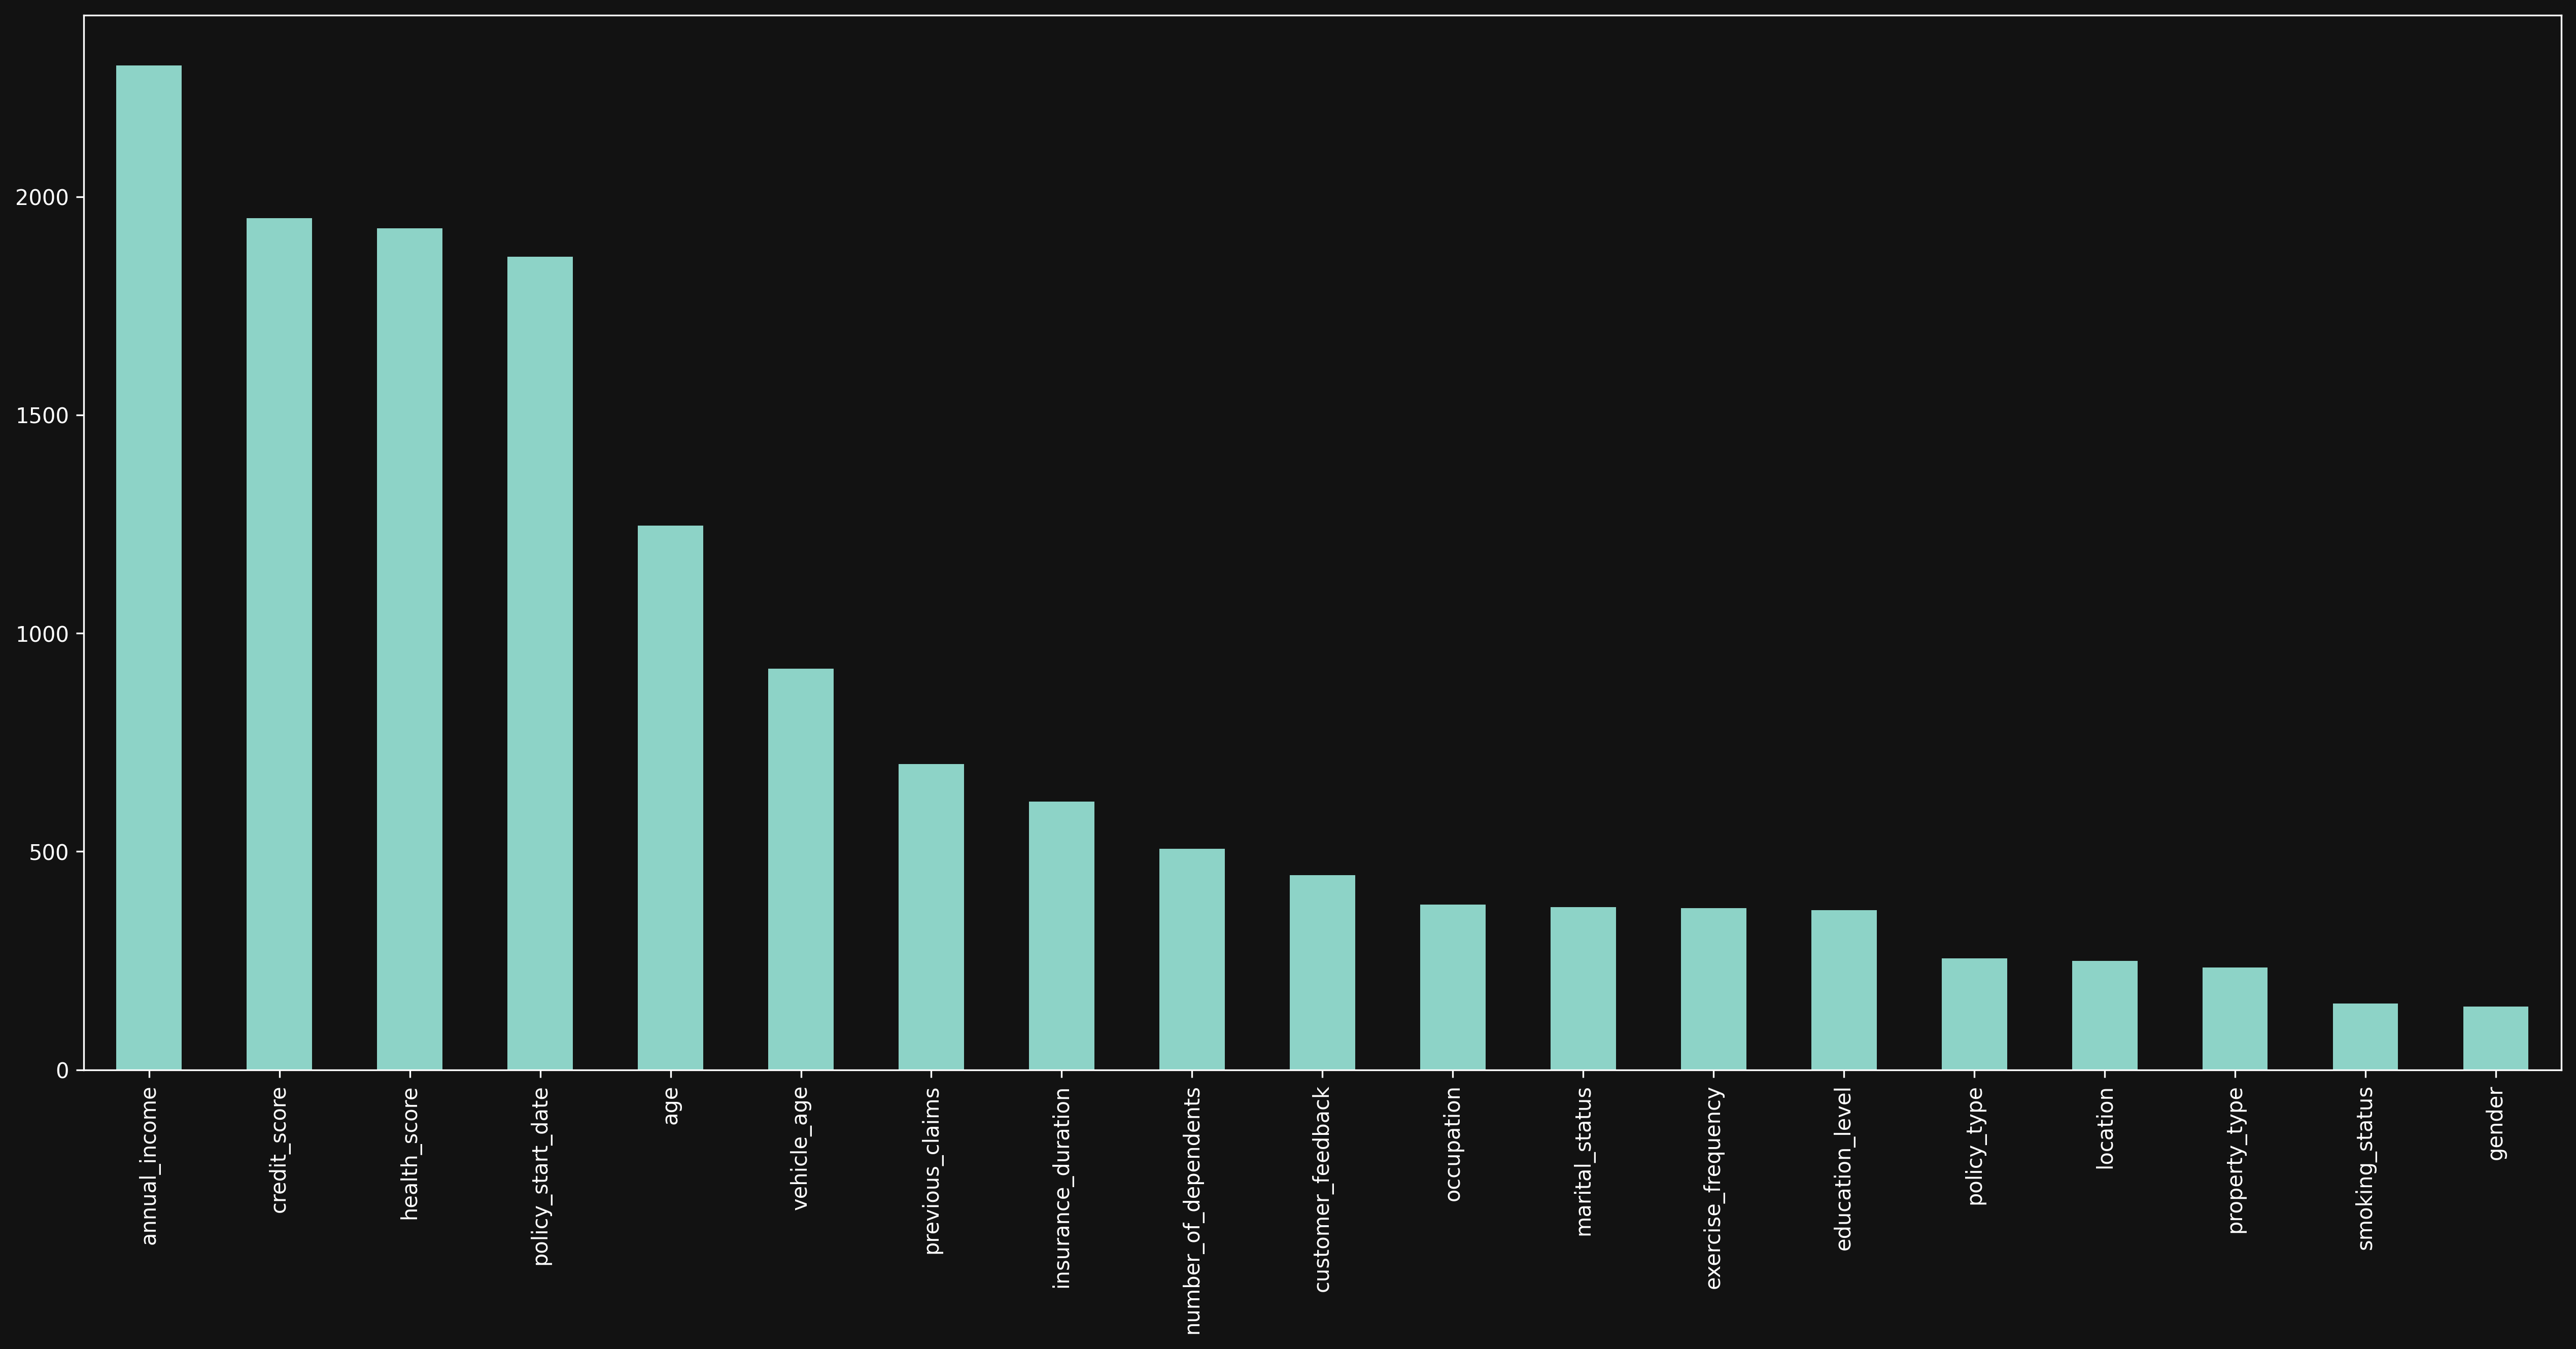

In [90]:
pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False).plot(kind='bar')
importance = pd.Series(lgbm.feature_importances_, index=X.columns).sort_values(ascending=False)

In [124]:
from sklearn.ensemble import StackingRegressor
# stack catboost, xgboost, lightgbm
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=1,
    # task_type='GPU'
)


xgbr = XGBRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    objective='reg:squarederror',
    # eval_metric='r2',
    gpu_id=0,
    # num_parallel_tree=1,
    # callbacks=[early_stop]
)

lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=30,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbosity=1,
)
print('fitting... catboost')
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
print('fitting... xgboost')
xgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
print('fitting... lightgbm')
lgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)])

estimators = [
    ('cbr', cbr),
    ('xgbr', xgbr),
    ('lgbm', lgbm)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, verbose=50)
)
print('fitting... stack')
stack.fit(X_train, y_train)

0:	learn: 0.9917899	test: 0.9928262	best: 0.9928262 (0)	total: 390ms	remaining: 3m 14s
50:	learn: 0.9293068	test: 0.9580273	best: 0.9576874 (31)	total: 9.89s	remaining: 1m 27s
100:	learn: 0.8917020	test: 0.9599244	best: 0.9576874 (31)	total: 19.5s	remaining: 1m 17s
150:	learn: 0.8610101	test: 0.9615506	best: 0.9576874 (31)	total: 29.4s	remaining: 1m 7s
200:	learn: 0.8400563	test: 0.9627412	best: 0.9576874 (31)	total: 42.3s	remaining: 1m 2s
250:	learn: 0.8177627	test: 0.9639827	best: 0.9576874 (31)	total: 53s	remaining: 52.5s
300:	learn: 0.7942851	test: 0.9656090	best: 0.9576874 (31)	total: 1m 3s	remaining: 42.1s
350:	learn: 0.7710823	test: 0.9672136	best: 0.9576874 (31)	total: 1m 13s	remaining: 31.3s
400:	learn: 0.7500571	test: 0.9687988	best: 0.9576874 (31)	total: 1m 24s	remaining: 20.9s
450:	learn: 0.7304150	test: 0.9701036	best: 0.9576874 (31)	total: 1m 34s	remaining: 10.3s
499:	learn: 0.7115925	test: 0.9714944	best: 0.9576874 (31)	total: 1m 44s	remaining: 0us

bestTest = 0.95768744

StackingRegressor(estimators=[('cbr',
                               <catboost.core.CatBoostRegressor object at 0x17bf6e090>),
                              ('xgbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=0, grow_po...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=-1,
                                            num_parallel_tree=None, ...)),
                              ('lgbm',
                               LGBMRegressor(max_depth=30, min_child_samples=7,
                                             min_child_weight=0.003,
                                             n_estimators=500, n_jobs=-1,
                                             random_state=42, verbosity=1))],
                  final_estimator=RandomForestRegressor(max_depth=20,
                                                        n_estimators=500,
                                                        n_jobs=-1,
                                                        random_state=42,
                                                        verbose=50))

In [125]:
evaluate_model(stack, X_val, y_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    0.2s
[Para

(0.08649293657367696, 0.9144881065351448, 1.0479243516327004)

In [ ]:
test = data[data[target_column].isna()].drop(columns=[target_column, 'policy_type', 'location', 'property_type', 'smoking_status', 'gender'])
stack_pred=stack.predict(test)

In [131]:
inverse_y(stack_pred)

array([787.61949332, 831.48962063, 803.0568907 , ..., 826.88374633,
       757.40566722, 792.6202044 ])

# RMLSE 평가 방식

In [28]:
# for lgboost
from typing import Tuple

# for lgboost
def rmlse(preds, dtrain: np.ndarray):
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False

def rmlse_with_inverse(preds, dtrain: np.ndarray):
    dtrain = inverse_y(dtrain)
    preds = inverse_y(preds)
    
    dtrain = np.log1p(dtrain)
    preds = np.log1p(preds)
    return 'RMLSE', np.sqrt(mean_squared_error(dtrain, preds)), False

# for catboost
class RMLSEMetricInv(object):
    @staticmethod
    def is_max_optimal():
        # RMLSE는 값이 작을수록 좋으므로 False 반환
        return False

    def evaluate(self, approxes, target, weight=None):
        """
        RMLSE 계산 함수.
        
        Args:
            approxes: 예측값의 리스트 (CatBoost에서 제공)
            target: 실제 타겟값
            weight: 가중치 (없을 수 있음, None 처리 필요)
        
        Returns:
            (error, weights sum)
        """
        # 예측값 가져오기
        preds = np.array(approxes[0])  # approxes는 리스트로 제공됨
        target = np.array(target)
        
        # invesre transform
        preds = inverse_y(preds)
        target = inverse_y(target)

        # 음수값 방지
        if np.any(target < 0) or np.any(preds < 0):
            raise ValueError("RMLSE cannot be calculated for negative values.")

        # 로그 변환
        preds = np.log1p(preds)
        target = np.log1p(target)

        error_sum = 0.0
        # 가중치 처리

        if weight is None:
            weight = np.ones(target.shape[0])
        
        error_sum = np.sum((weight * (preds - target) ** 2) * weight) / target.shape[0]
        weight_sum = np.sum(weight)

        return error_sum, weight_sum

    def get_final_error(self, error, weight):
        """
        최종 에러 값 반환.
        
        Args:
            error: RMLSE 값
            weight: 가중치 합계
        
        Returns:
            최종 RMLSE 값
        """
        return np.sqrt(error / (weight + 1e-38))  # RMLSE 자체를 최종 결과로 반환
    
class RMLSEMetric(object):
    @staticmethod
    def is_max_optimal():
        # RMLSE는 값이 작을수록 좋으므로 False 반환
        return False

    def evaluate(self, approxes, target, weight=None):
        """
        RMLSE 계산 함수.
        
        Args:
            approxes: 예측값의 리스트 (CatBoost에서 제공)
            target: 실제 타겟값
            weight: 가중치 (없을 수 있음, None 처리 필요)
        
        Returns:
            (error, weights sum)
        """
        if weight is None:
            weight = np.ones(target.shape[0])
        # 예측값 가져오기
        preds = np.array(approxes[0])  # approxes는 리스트로 제공됨
        target = np.array(target)


        # 음수값 방지
        if np.any(target < 0) or np.any(preds < 0):
            return 1e6, np.sum(weight)

        # 로그 변환
        preds = np.log1p(preds)
        target = np.log1p(target)

        error_sum = 0.0
        # 가중치 처리

        
        error_sum = np.sum((weight * (preds - target) ** 2) * weight) / target.shape[0]
        weight_sum = np.sum(weight)

        return error_sum, weight_sum

    def get_final_error(self, error, weight):
        """
        최종 에러 값 반환.
        
        Args:
            error: RMLSE 값
            weight: 가중치 합계
        
        Returns:
            최종 RMLSE 값
        """
        return np.sqrt(error / (weight + 1e-38))  # RMLSE 자체를 최종 결과로 반환

# for xgboost
def rmlse_objective_with_inverse(labels, preds):
    y = inverse_y(labels)
    yhat = inverse_y(preds)
    eps = 1e-6 # + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)

    diff = (log1p_yhat - log1p_y)

    grad = diff / (yhat + 1.0)
    hess = (1 - diff) / np.power(yhat + 1.0, 2)

    return grad, hess

def rmlse_evaluation_with_inverse(labels, preds):
    y = inverse_y(labels)
    yhat = inverse_y(preds)
    n = y.shape[0]
    eps = 1e-6
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)
    rmlse = np.sqrt(np.sum((log1p_yhat - log1p_y)**2)) / n
    return rmlse


def rmlse_objective(labels, preds):
    y = labels
    yhat = preds
    eps = 1e-6 + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)

    diff = (log1p_yhat - log1p_y)

    grad = diff / (yhat + 1.0)
    hess = (1 - diff) / np.power(yhat + 1.0, 2)

    return grad, hess

def rmlse_evaluation(labels, preds):
    y = labels
    yhat = preds
    n = y.shape[0]
    eps = 1e-6 + 1
    y = np.maximum(labels, eps)  # Ensure preds >= 0
    yhat = np.maximum(preds, eps)  # Ensure labels >= 0
    log1p_y = np.log1p(y)
    log1p_yhat = np.log1p(yhat)
    rmlse = np.sqrt(np.sum((log1p_yhat - log1p_y)**2)) / n
    return rmlse

def gradient(labels: np.ndarray, preds: np.ndarray) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    return (np.log1p(preds) - np.log1p(labels)) / (preds + 1)

def hessian(labels: np.ndarray, preds: np.ndarray) -> np.ndarray:
    '''Compute the hessian for squared log error.'''

    return ((-np.log1p(preds) + np.log1p(labels) + 1) /
            np.power(preds + 1, 2))

def squared_log(labels: np.ndarray,
                preds: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    labels[labels < -1] = -1 + 1e-6
    grad = gradient(labels, preds)
    hess = hessian(labels, preds)
    return grad, hess

In [362]:
# early_stopping_rounds
early_stop = xgb.callback.EarlyStopping(
    rounds=10, data_name='validation_0', save_best=True,# metric_name='rmse',
)
xgbr = XGBRegressor(
    n_estimators=500,
    disable_default_eval_metric=True,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # objective='reg:squaredlogerror',
    # objective=squared_log,
    objective=rmlse_objective,
    eval_metric=rmlse_evaluation,
    gpu_id=0,
    # num_parallel_tree=1,
    callbacks=[early_stop]
)
xgbr.fit(X_train, inverse_y(y_train), eval_set=[(X_train, inverse_y(y_train)), (X_val, inverse_y(y_val))], verbose=10)

[0]	validation_0-rmlse_evaluation:0.00613	validation_1-rmlse_evaluation:0.01225
[10]	validation_0-rmlse_evaluation:0.00547	validation_1-rmlse_evaluation:0.01093
[20]	validation_0-rmlse_evaluation:0.00467	validation_1-rmlse_evaluation:0.00935
[30]	validation_0-rmlse_evaluation:0.00391	validation_1-rmlse_evaluation:0.00782
[40]	validation_0-rmlse_evaluation:0.00319	validation_1-rmlse_evaluation:0.00639
[50]	validation_0-rmlse_evaluation:0.00254	validation_1-rmlse_evaluation:0.00508
[60]	validation_0-rmlse_evaluation:0.00198	validation_1-rmlse_evaluation:0.00396
[70]	validation_0-rmlse_evaluation:0.00155	validation_1-rmlse_evaluation:0.00310
[80]	validation_0-rmlse_evaluation:0.00129	validation_1-rmlse_evaluation:0.00258
[90]	validation_0-rmlse_evaluation:0.00117	validation_1-rmlse_evaluation:0.00234
[100]	validation_0-rmlse_evaluation:0.00113	validation_1-rmlse_evaluation:0.00226
[110]	validation_0-rmlse_evaluation:0.00111	validation_1-rmlse_evaluation:0.00223
[120]	validation_0-rmlse_ev

XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x3001b61e0>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None,
             disable_default_eval_metric=True, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function rmlse_evaluation at 0x30019c220>,
             feature_types=None, gamma=None, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, ...)

In [364]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.2166216956468372, 909163.8569230675, 1.0846654976421648)

In [323]:
evaluate_model_no_inverse(xgbr, X_val, inverse_y(y_val))

(-0.21583451785926044, 908575.6103086942, 1.0847206771631082)

In [384]:
# catboost with rmlse
cbr = cat.CatBoostRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    random_state=42,
    verbose=10,
    eval_metric=RMLSEMetricInv()
)
cbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=30)
evaluate_model(cbr, X_val, y_val)

0:	learn: 0.0011092	test: 0.0022208	best: 0.0022208 (0)	total: 331ms	remaining: 2m 45s
10:	learn: 0.0010717	test: 0.0021529	best: 0.0021529 (10)	total: 2.26s	remaining: 1m 40s
20:	learn: 0.0010618	test: 0.0021437	best: 0.0021437 (20)	total: 4.54s	remaining: 1m 43s
30:	learn: 0.0010542	test: 0.0021423	best: 0.0021423 (30)	total: 6.54s	remaining: 1m 38s
40:	learn: 0.0010465	test: 0.0021428	best: 0.0021422 (31)	total: 8.6s	remaining: 1m 36s
50:	learn: 0.0010394	test: 0.0021430	best: 0.0021422 (31)	total: 10.9s	remaining: 1m 35s
60:	learn: 0.0010313	test: 0.0021436	best: 0.0021422 (31)	total: 13s	remaining: 1m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.002142195343
bestIteration = 31

Shrink model to first 32 iterations.


(0.08381867950551047, 0.9171652355695751, 1.049457109954584)

In [29]:
lgbr = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # verbosity=1,
)

lgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=rmlse_with_inverse)
evaluate_model(lgbr, X_val, y_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 14
[LightGBM] [Info] Start training from score -0.000037


(0.0886444581018001, 0.9123342744224042, 1.0466895714082922)

In [ ]:
evaluate_model(lgbr, X_val, y_val)

(0.0886444581018001, 0.9123342744224042, 1.0466895714082922)

In [ ]:
# SVM
from sklearn.svm import SVR
svr = SVR(
    C=1,
    epsilon=2.25,
)
svr.fit(X_train, y_train)

In [218]:
import pickle
svr = pd.read_pickle('svr.pkl')

In [75]:
# save svr model because it takes too long to train
import pickle
with open('svr.pkl', 'wb') as f:
    pickle.dump(svr, f)

In [220]:
evaluate_model(svr, X_val[:, 1:], y_val)

(-0.41186115869286777, 1.4133773994706387, 1.3027766711381177)

# Submission

In [50]:
test = data[data[target_column].isna()].drop(columns=[target_column])

In [52]:
def make_ans(model):
    ans=inverse_y(model.predict(test.values))
    return pd.Series(ans, index = test.index).rename('Premium Amount')

In [54]:
ans = make_ans(lgbm)
ans.to_csv('submission.csv', header=True)